In [1]:
import config
from tools import dataloader, preprocess

In [2]:
import os
import numpy as np
import open3d as o3d
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from IPython.display import clear_output

/home/vglasov/Reseach/LU-Net-pytorch/tools/preprocess.py:77: RuntimeWarning: invalid value encountered in greater
  labels = template.join(lb).unstack(fill_value=0.).values[::-1, :] > 0


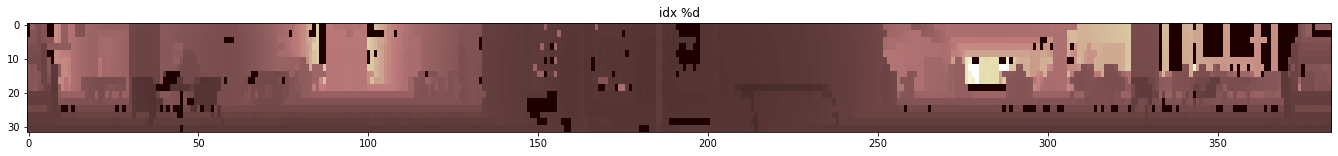

In [3]:
#combine background image from two empty ones
pcd_left = o3d.read_point_cloud("/home/vglasov/datasets/L_CAS_3D_Point_Cloud_People_Dataset/3D Point Cloud People Dataset/LCAS_20160523_1200_1218_pcd/1464001282.123002000.pcd")
pcd_right = o3d.read_point_cloud("/home/vglasov/datasets/L_CAS_3D_Point_Cloud_People_Dataset/3D Point Cloud People Dataset/LCAS_20160523_1200_1218_pcd/1464001870.391430000.pcd")
pcd_background = o3d.crop_point_cloud(pcd_left, [-100., -100., -100.], [0., 100., 100.]) + \
      o3d.crop_point_cloud(pcd_right, [0., -100., -100.], [100., 100., 100.])

o3d.write_point_cloud("data/background.pcd", pcd_background)

pcd2img = preprocess.Pcd2ImageTransform().fit(pcd_background, [])
range_image, mask, labels = pcd2img.transform()
range_image = np.nan_to_num(range_image)

X, _, y = range_image[None, :, :], mask, labels
plt.figure(figsize=(24, 2))
plt.imshow(np.repeat(X[0, :, :], 2, axis=0), cmap='pink')
plt.imshow(np.repeat(y, 2, axis=0), cmap=ListedColormap([[0., 0., 0., 0.], [0., 0., 1., 0.25]]))
plt.title("idx %d")
plt.show()

In [4]:
#fetch all bodies

def fetch_bodies(path):
    landmarks_frame = pd.read_csv(path)

    def read_labels(labels_path):
        return [list(map(float, f.split()[4:10])) for f in open(labels_path, "r").readlines()]

    pcds = []
    pcd_dist = []
    pcd_size = []

    for idx, pcd_path, labels_path in landmarks_frame.itertuples():
        pcd = o3d.read_point_cloud(pcd_path)
        labels_list = read_labels(labels_path)

        for x_min, y_min, z_min, x_max, y_max, z_max in labels_list:
            croped_pcd = o3d.crop_point_cloud(pcd, [x_min, y_min, z_min], [x_max, y_max, z_max])
            pcds += [(croped_pcd, x_min, y_min, z_min, x_max, y_max, z_max)]
            pcd_dist += [np.linalg.norm(croped_pcd.points, axis=1).mean()]
            pcd_size += [len(croped_pcd.points)]
            
    return np.array(pcds), pcd_dist, pcd_size
    
train_pcds, _, _ = fetch_bodies("data/train.csv")
test_pcds, _, _ = fetch_bodies("data/test.csv")

In [5]:
import uuid
def synthetic_data_generator(pcds, N):
    pcd_paths = []
    label_paths = []
    for idx in range(N):
        file_name = str(uuid.uuid4())
        
        pedestrian_number = np.random.randint(1, 7)
        pedestrians = pcds[np.random.choice(len(pcds), size=pedestrian_number, replace=False)]
        
        write_to_pcd = o3d.PointCloud(pcd_background)
        label = open(config.synthetic_dataset + "labels/" + file_name + ".txt", "w")
        
        for pcd, x_min, y_min, z_min, x_max, y_max, z_max in pedestrians:
            write_to_pcd += pcd
            label.write("pedestrian 0 0 0 %f %f %f %f %f %f 0\n" % (x_min, y_min, z_min, x_max, y_max, z_max))
        
        o3d.write_point_cloud(config.synthetic_dataset + "pcd/" + file_name + ".pcd", write_to_pcd)
        label.close()
        pcd_paths += [config.synthetic_dataset + "pcd/" + file_name + ".pcd"]
        label_paths += [config.synthetic_dataset + "labels/" + file_name + ".txt"]
        
    return pd.DataFrame({"pcd": pcd_paths, "labels": label_paths})

In [24]:
df = synthetic_data_generator(train_pcds, 10000)
df.to_csv("data/synthetic_train.csv", index=False)

In [25]:
df = synthetic_data_generator(test_pcds, 1000)
df.to_csv("data/synthetic_test.csv", index=False)